# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.



In [0]:
student1 = "Lingjing Kong"
student2 = "Jiahua Wu"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [0]:
%matplotlib inline

import random
random.seed(6) # Python random seed
import numpy as np
np.random.seed(6) # Numpy random seed
from tensorflow import set_random_seed
set_random_seed(6) # Tensorflow random seed

import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.regularizers import l1_l2

Using TensorFlow backend.


### Plotting

In [0]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

  # This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [0]:
# Dense layer model constructor 
def dense_model_constructor(input_size=784, 
                            layer_list=[128, 10], # number of neurons of each layer 
                            batchnorm=False,
                            weight_reg=[0, 0],    # L1 and L2 regularization parameters for weights
                            bias_reg=[0, 0],      # L1 and L2 regularization parameters for biases
                            dropout=0,            # default 0; no dropout
                            hidden_activation='relu', 
                            output_activation='softmax',
                            verbose=True):        # wether to display model summary
    model = Sequential()
    
    # input layer
    model.add(Dense(units=layer_list[0], 
                    activation=hidden_activation,
                    input_shape=(input_size,)))
    
    # dropout layer (optional)
    if dropout != 0:
        model.add(Dropout(dropout))
    
    # hidden layers
    for layer_size in layer_list[1: -1]: 
        model.add(Dense(units=layer_size, 
                      activation=hidden_activation,
                      kernel_regularizer=l1_l2(weight_reg[0], weight_reg[1]),
                      bias_regularizer=l1_l2(bias_reg[0], bias_reg[1])))
      # batchnorm (optional)
        if batchnorm:
            model.add(BatchNormalization())
      
      # dropout (optional)
        if dropout != 0:
            model.add(Dropout(dropout))      
        
    # output layer
    model.add(Dense(units=layer_list[-1], activation=output_activation))
    
    # display summary
    if verbose:
        model.summary()
    
    return model

## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

Step 1: import datasets

In [0]:
from keras.datasets import mnist, fashion_mnist

# load into variables
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 2s 0us/step


step 2: plot some data

please note here we modified the orginal plot_some_samples function to make the label and data consistent

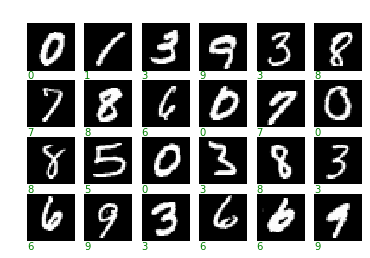

In [0]:
# plot mnist 
fig_mnist = plot_some_samples(x=x_train, y=y_train, 
                              ncols = 6, nrows = 4, 
                              xdim = 28, ydim = 28,
                              label_mapping = range(10))

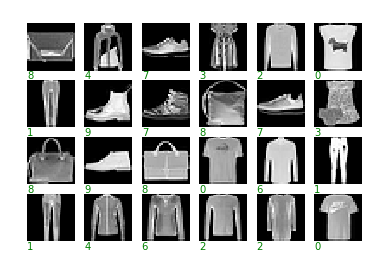

In [0]:
# plot fashion mnist
fig_fashion = plot_some_samples(x=x_fashion_train, y = y_fashion_train, 
                                ncols = 6, nrows = 4, 
                                xdim = 28, ydim = 28,
                                label_mapping = range(10))

**Answer to question 2**:  
**The green digit on the bottom left of each subplot is the label (trarin target) assigned to this image. (please note we modified the orginal plot_some_sample function)**

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [0]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the **softmax activation** for the output layer.
2. Use the **categorical_crossentropy loss**.
3. Add the **accuracy metric** to the metrics.
4. Choose **stochastic gradient descent** for the optimizer.
5. Choose a **minibatch size of 128**.
6. **Fit for as many epochs as needed** to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function **plot_history** defined above.
8. **Determine the indices of all test images that are misclassified** by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. **Explain the green and red digits at the bottom of each image.**
9. **Repeat the above steps for fitting the network to the Fashion-MNIST dataset.**


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Step 1: construct a no-hidden-layer model and use the softmax activation function for the output layer

In [0]:
# define the model
num_classes = 10
model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=(784,)))

# save the initial weights for later use
initial_weights = model.get_weights()

# check
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Step 2, 3, 4: use the categorical crossentropy loss, add the accuracy metric, choose stochastic gradient descent for the optimizer.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

Step 5, 6: Choose a minibatch size of 128 and Fit for as many epoches as needed until no decrease in validation loss is seen.

In [0]:
# minibatch size
batch_size = 128
epochs = 100

# training
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

step 7: Plot the output of the fitting procedure (a history object) using the function plot_history defined above.

Test loss: 0.2648310517221689
Test accuracy: 0.9262


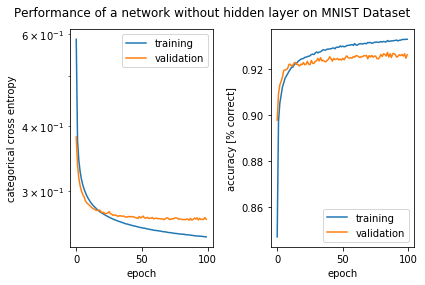

In [0]:
# Plot the history object.
plot_history(history, 'Performance of a network without hidden layer on MNIST Dataset')
print('Test loss:', score[0])
print('Test accuracy:', score[1]) 

step 8: Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function plot_some_samples(x_test, y_test, yhat_test, error_indices).

Number of misclassified objects:  738


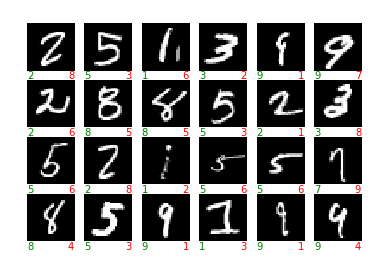

In [0]:
# Find indices of misclassified test images
pred = model.predict_classes(x_test, batch_size=128, verbose=0)

# Transform the target into classes using np.argmax and then compare it to the predictions
error_indices = np.nonzero(pred != np.argmax(y_test, axis=1))[0]
print("Number of misclassified objects: ", error_indices.shape[0])

fig_misclassification = plot_some_samples(x_test, y_test, pred, error_indices)

**Answer to question 8**: 

**The green digit represents the true label for the image and the red one represents the wrong prediction made by our model.**. 

step 9: Repeat on the fashion-MNIST Dataset

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.4359002549648285
Test accuracy: 0.8426
Number of misclassified objects:  1574


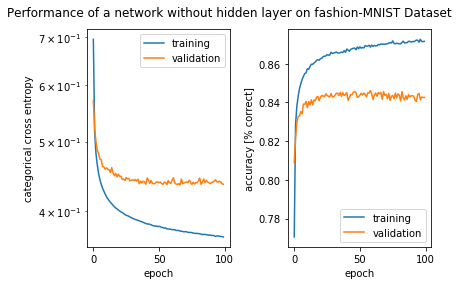

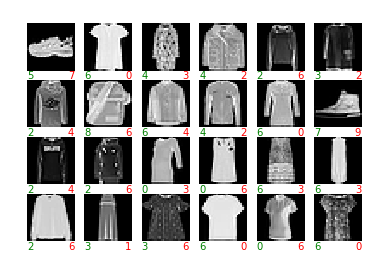

In [0]:
# re-construct the model
model.set_weights(initial_weights)

# Print out the details of the model
model.summary()

# Use categorical crossentropy as loss function and train the model with SGD
model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
            metrics=['accuracy'])

# Save the output of the fitting procedure as history object.
history = model.fit(x_fashion_train, y_fashion_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_fashion_test, y_fashion_test))

# test
score = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)

# Plot the history object.
plot_history(history, 'Performance of a network without hidden layer on fashion-MNIST Dataset')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Find indices of misclassified test images
pred = model.predict_classes(x_fashion_test, batch_size=128, verbose=0)

# Transform the target into classes using np.argmax and then compare it to the predictions
error_indices = np.nonzero(pred != np.argmax(y_fashion_test,axis=1))[0]
print("Number of misclassified objects: ", error_indices.shape[0])

fig = plot_some_samples(x_fashion_test, y_fashion_test, pred, error_indices)

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

step 1: one hidden layer with 128 units and 'relu' 

pleae note here we are using our dense model constructor function

In [0]:
# build with defined model constructor 
model_one_hidden = dense_model_constructor(layer_list=[128, 10], # number of neurons for each layer
                                          hidden_activation='relu',
                                          output_activation='softmax',
                                          verbose=True)         # display summary or not

# save the initial weights for later use
initial_weights = model_one_hidden.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


step 2: fit 50 epochs with SGD of different learning rates

In [0]:
# Here the range is large in order to show the different behaviours of SGD among a large range of lrs
lr_list = np.logspace(base=10, start=-4, stop=0, num=5)
lr_list = np.append(lr_list, 2)
print(lr_list)

epochs = 50
optimizer = SGD
batch_size = x_train.shape[0] // 100
histories_SGD = list()

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 2.e+00]


In [0]:
# training with different lrs
for lr in lr_list:
     # for fair comparison, start with the same initialization
    model_one_hidden.set_weights(initial_weights)
    
    model_one_hidden.compile(loss='categorical_crossentropy',
                               optimizer=optimizer(lr=lr),
                               metrics=['accuracy'])
    
    history = model_one_hidden.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=0,
                                validation_data=(x_test, y_test))
    histories_SGD.append(history)

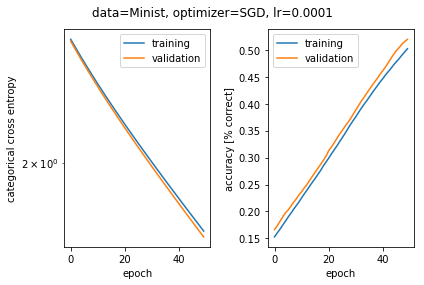

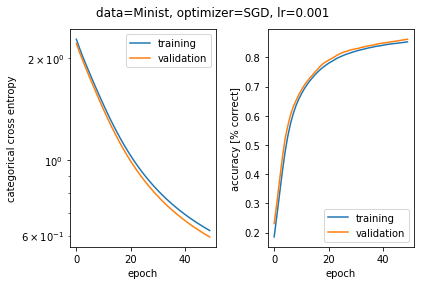

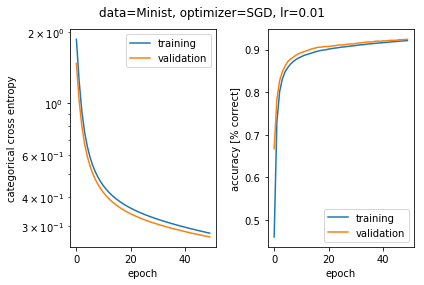

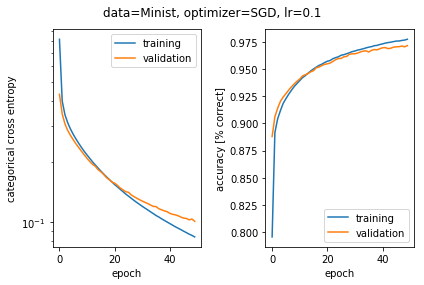

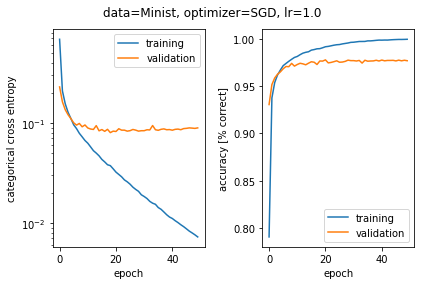

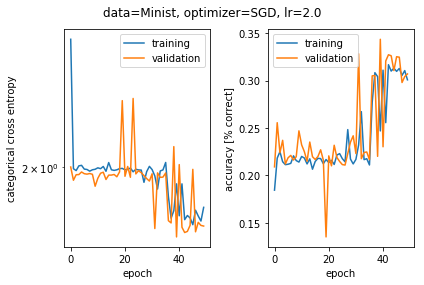

In [0]:
# visualize the learning curves for SGD at different lrs
for history, lr in zip(histories_SGD, lr_list):
    title = 'data=Mnist, optimizer=SGD, lr=' + str(lr)
    plot_history(history, title=title)

Observations: with small lrs (1e-4, 1e-3), SGD cannot fully optimize the model as each stepsize is too small to converge in the fixed training epoch number. Whereas for large lrs (2), SGD is extremely unstable as the stepsize is too large and SGD oscillates at areas away from minima.

step 3: replace SGD with Adam and repeat the running with other settings the same

In [0]:
# repeat the process for Adam
optimizer = Adam
histories_adam = list()

for lr in lr_list:
    # with the same initialization
    model_one_hidden.set_weights(initial_weights)
    
    model_one_hidden.compile(loss='categorical_crossentropy',
                             optimizer=optimizer(lr=lr),
                             metrics=['accuracy'])
    
    history = model_one_hidden.fit(x_train, y_train,
                                   batch_size=batch_size,
                                   epochs=epochs,
                                   verbose=0,
                                   validation_data=(x_test, y_test))
    
    histories_adam.append(history)

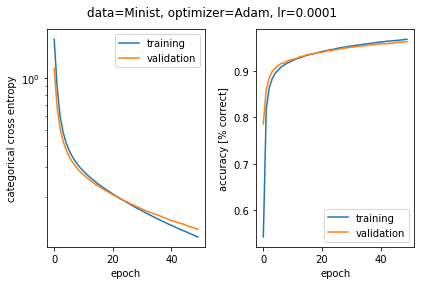

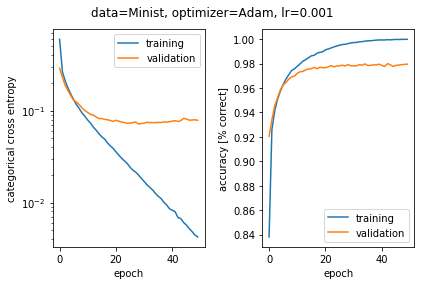

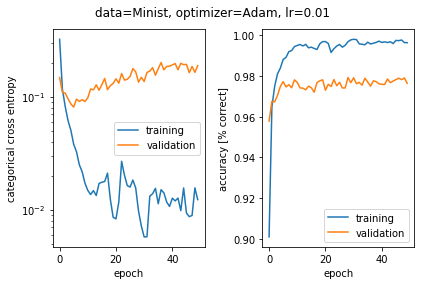

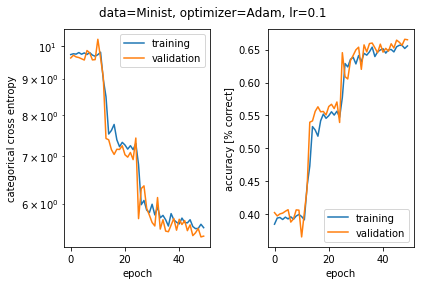

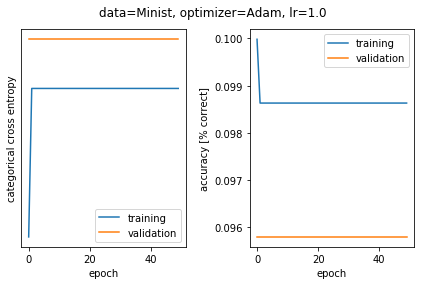

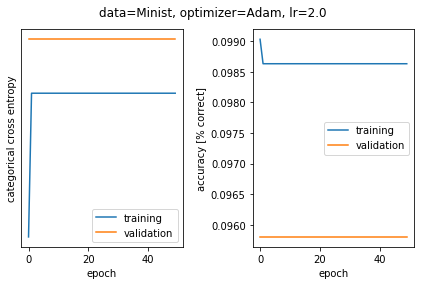

In [0]:
# visualize the learning curves for Adam at different lrs
for history, lr in zip(histories_adam, lr_list):
    title = 'data=Mnist, optimizer=Adam, lr=' + str(lr)
    plot_history(history, title=title)

Observations: It seems that small learning rates suit Adam better than SGD, at small lrs (1e-4, 1e-3), Adam can already achieve decent optimization and have accuracy over 90%. At relatively large lrs (1e-2, 1e-1), significant oscillations appear, inidicating the algorithm jumps around the minima.

step 4: Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure.

Here we plot Adam and SGD at lr=1e-2, and 1e-1 repectively.

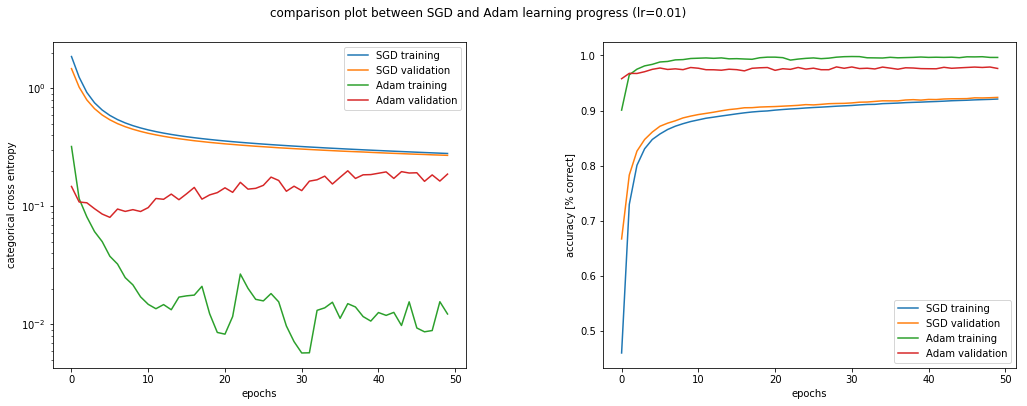

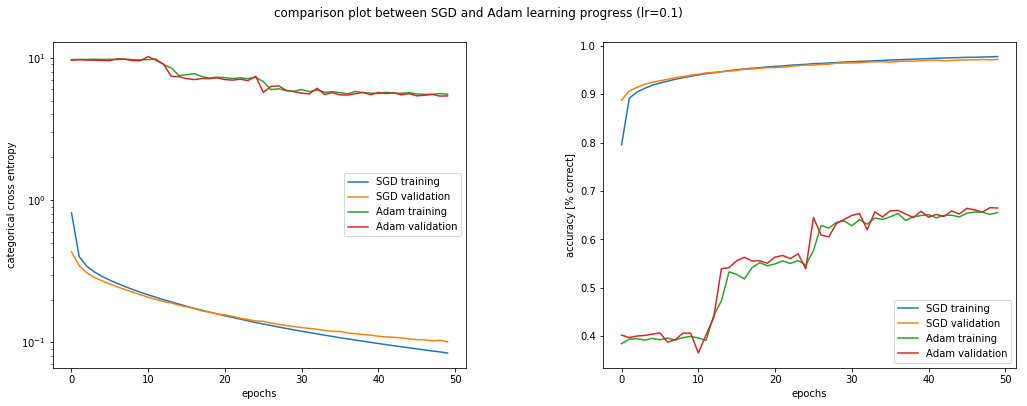

In [0]:
# lr = 1e-2
comparison_fig_1 = comparison_plot(history_sgd=histories_SGD[2], 
                                history_adam=histories_adam[2],
                                label1='SGD',
                                label2='Adam',
                                title='comparison plot between SGD and Adam learning progress (lr=0.01)')
comparison_fig_1.set_figheight(6)
comparison_fig_1.set_figwidth(16)

# lr = 1e-1
comparison_fig_2 = comparison_plot(history_sgd=histories_SGD[3], 
                                history_adam=histories_adam[3],
                                label1='SGD',
                                label2='Adam',
                                title='comparison plot between SGD and Adam learning progress (lr=0.1)')
comparison_fig_2.set_figheight(6)
comparison_fig_2.set_figwidth(16)

Observation: At lr=1e-2, Adam converges much faster than SGD and overfitting can be observed in Adam's loss curves (validation loss goes up after some point). Also, Adam exhibits evident oscillations. However, at lr=1e-1, SGD outperforms Adam with much lower losses and higher accuracies.

step 5: answer required questions

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) As plotted in the step 2, SGD  (lr=2) oscillates dramatricall and cannot converge to a decent minima stably.

B) As plotted in the step 2, SGD (lr=1e-4) optimizes the model very lowly and cannot reach a minima with the fixed training epoch number.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: At lr=1e-2, Adam overfits the model at epcoh 8 approximately, where the validation loss starts to rise.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 
For loss curves, the sign of overfitting is the turning point (bottom of the U shape) of the validation loss curve. 
For Accuracy curves, the sign of overfitting is approximately the point where validation accuracy  reaches certain level and starts to oscillate.

 step 6: run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves.

In [0]:
optimizer = Adam
lr = 1e-3

# with the same initialization
model_one_hidden.set_weights(initial_weights)

model_one_hidden.compile(loss='categorical_crossentropy',
                         optimizer=optimizer(lr=lr),
                         metrics=['accuracy'])

history_fashion_one_hidden_adam = model_one_hidden.fit(x_fashion_train, y_fashion_train,
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      verbose=0,
                                                      validation_data=(x_fashion_test, y_fashion_test))

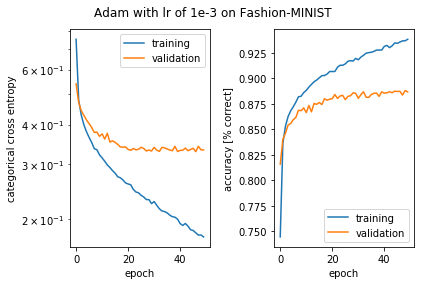

In [0]:
# plot the learning curves
plot_history(history_fashion_one_hidden_adam, 'Adam with lr of 1e-3 on Fashion-MNIST')
plt.show()

Observation: with the same model and optimizer, the performance on Fashion data set is noticeably lower than that on the MNIST dataset.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the **best validation loss and accuracy** depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best **validation loss and accuracy** versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)

3. **Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)**
In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

step1: Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset.

Please note: the random seeds for Python, Tensorflow and Numpy have been fixed at the beginning of this file.

In [0]:
# Make sure each model has been fully trained 
epochs = 200
# Define considered hidden sizes 
hidden_size = [10,50,100,300,500,1000]

# Initialize useful variables
batch_size = 128
num_classes = 10
best_val_loss = []
best_val_acc = []

# history records
neuron_histories_mnist = list()

for hid_size in hidden_size:
  
    # Define the network with one hidden layer and using softmax as activation function
    model = dense_model_constructor(input_size=784, 
                                    layer_list=[hid_size, num_classes], 
                                    hidden_activation='relu', 
                                    output_activation='softmax',
                                    verbose=False)
    
    # Print out the details of the model
    model.summary()
    
    # Use categorical crossentropy as the loss function and train the model with Adam
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=1e-4),
                  metrics=['accuracy'])
    
    # Save the output of the fitting procedure as a history object.
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test))    
    neuron_histories_mnist.append(history)
    
    # Pick out the best validation loss
    best_val_loss.append(min(history.history['val_loss']))
    best_val_acc.append(max(history.history['val_acc']))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Laye

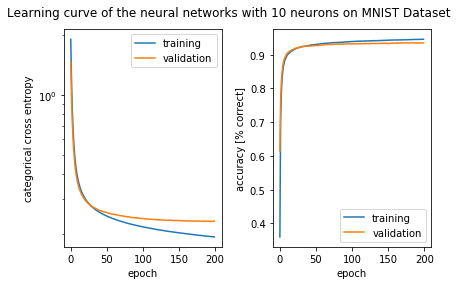

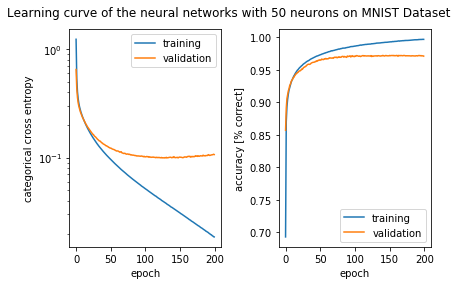

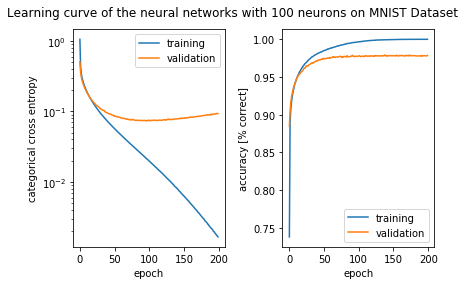

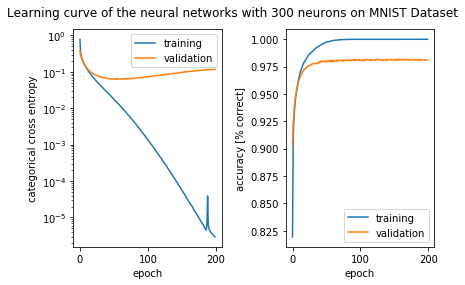

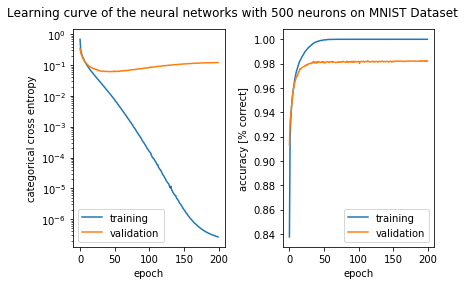

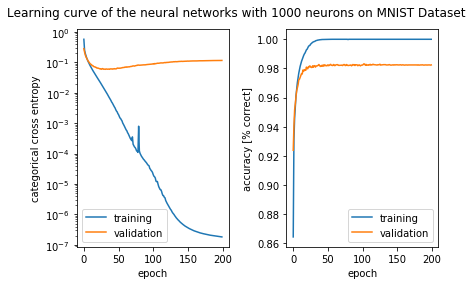

In [0]:
# visualize the training process
for hid_size, neuron_history in zip(hidden_size, neuron_histories_mnist):
    _ = plot_history(neuron_history,'Learning curve of the neural networks with '+str(hid_size)+' neurons on MNIST Dataset')

step2: Plot the best validation loss and accuracy versus the number of hidden neurons.

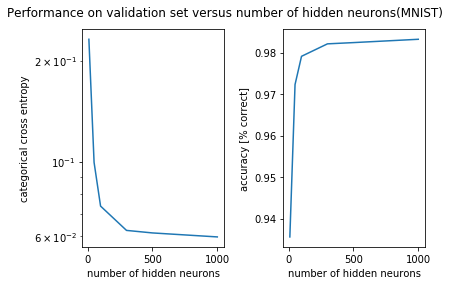

In [0]:
fig, ax1, ax2 = prepare_standardplot('Performance on validation set versus number of hidden neurons(MNIST)', 'number of hidden neurons')
ax1.plot(hidden_size,best_val_loss)
ax2.plot(hidden_size,best_val_acc)
finalize_standardplot(fig, ax1, ax2)

**Answer to question 2**: 

**The trend does not obey the general approximation theorem, as the validation loss starts to plateaus somewhere around 0.06 instead of converging to 0.
Although with sufficient neurons a single layer model can potentially fit the training data completely, such a model cannot generalize perfectly to unseen validation data, due to the limited number of training samples.**

step3: Repeat on fashion-MNIST Dataset

In [0]:
# Make sure each model has been fully trained
epochs = 200

# Define hidden sizes considered
hidden_size = [10,50,100,300,500,1000]

# Initialize useful variables
batch_size = 128
num_classes = 10
best_val_loss = []
best_val_acc = []

# histories
neuron_histories_fashion = list()

for hid_size in hidden_size:
  
    # Define the network with one hidden layer and using softmax as activation function
    model = dense_model_constructor(input_size=784, 
                                    layer_list=[hid_size, num_classes], 
                                    hidden_activation='relu', 
                                    output_activation='softmax',
                                    verbose=False)  
    # Use categorical crossentropy as loss function and trian the model with Adam
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    # Save the output of the fitting procedure as history object.
    history = model.fit(x_fashion_train, y_fashion_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_fashion_test, y_fashion_test))
    neuron_histories_fashion.append(history)

    best_val_loss.append(min(history.history['val_loss']))
    best_val_acc.append(max(history.history['val_acc']))

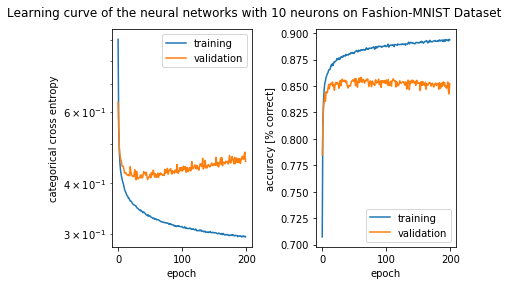

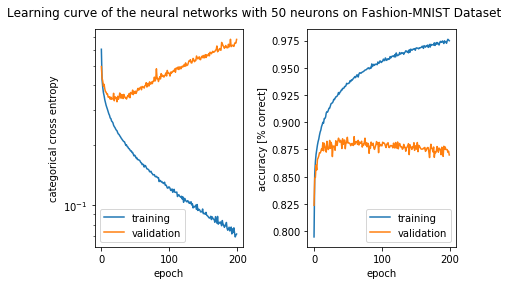

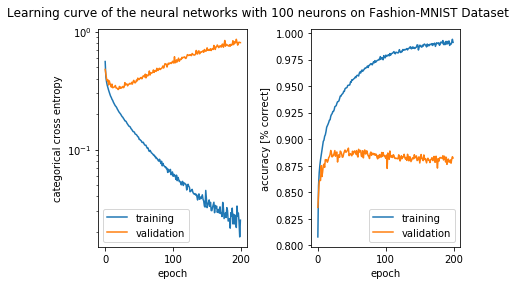

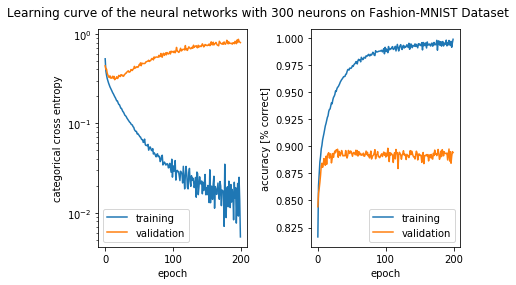

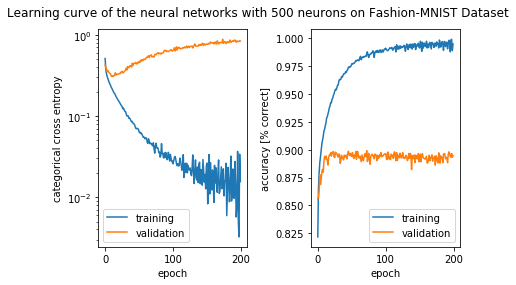

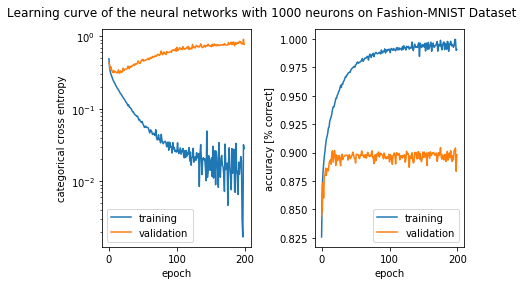

In [0]:
# visualize the training process
for hid_size, neuron_history in zip(hidden_size, neuron_histories_fashion):
    _ = plot_history(neuron_history,'Learning curve of the neural networks with '+str(hid_size)+' neurons on Fashion-MNIST Dataset')

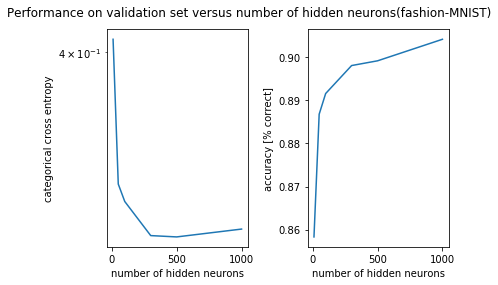

In [0]:
# plotting
fig, ax1, ax2 = prepare_standardplot('Performance on validation set versus number of hidden neurons(fashion-MNIST)','number of hidden neurons')
ax1.plot(hidden_size,best_val_loss)
ax2.plot(hidden_size,best_val_acc)
finalize_standardplot(fig, ax1, ax2)

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

step 1: train a model with two more layers 

Please note: here we assume 'adding one or two hidden layers' refers to adding extra hidden layers to the one-hidden layer model defined in Exercise 3. 

In [0]:
# a model with two more hidden layers (50 units each)
naive_model_three_hidden = dense_model_constructor(input_size=784, 
                                                   layer_list=[128, 50, 50, 10], 
                                                   hidden_activation='relu', 
                                                   output_activation='softmax')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
Total params: 109,990
Trainable params: 109,990
Non-trainable params: 0
_________________________________________________________________


In [0]:
# training parameters
lr = 1e-3
epochs = 100
optimizer = Adam
batch_size = x_fashion_train.shape[0] // 100

# compile
naive_model_three_hidden.compile(loss='categorical_crossentropy',
                                optimizer=optimizer(lr=lr),
                                metrics=['accuracy'])

In [0]:
# training
naive_history = naive_model_three_hidden.fit(x_fashion_train, y_fashion_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            verbose=0,
                                            validation_data=(x_fashion_test, y_fashion_test))

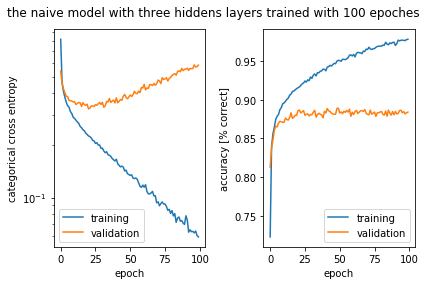

The best validation error is:  0.8892999935150147
The best validation loss is:  0.32490877151489256


In [0]:
# plot 
plot_history(naive_history, 'the naive model with three hiddens layers trained with 100 epoches')
plt.show()

# print performance
print('The best validation error is: ', max(naive_history.history['val_acc']))
print('The best validation loss is: ', min(naive_history.history['val_loss']))

Observation: there is a clear sign of overfitting for this naive model at around the 25th epoch.

After multiple trials, we choose a model with batchnormalization, dropout=0.2 after each hidden layer and L2_regularization=1e-2 for each hidden layer weight.

In [0]:
# construction
tuned_model_three_hidden = dense_model_constructor(
                                                   layer_list=[128, 50, 50, 10], 
                                                   batchnorm=True,
                                                   dropout=0.2,
                                                   weight_reg=[0, 0.01],
                                                   bias_reg=[0, 0],
                                                   hidden_activation='relu', 
                                                   output_activation='softmax')

# save inital weights for later use
tuned_three_hidden_inital = tuned_model_three_hidden.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
__________

In [0]:
# training on Fashion data
lr = 1e-3
epochs = 100
optimizer = Adam
tuned_model_three_hidden.compile(loss='categorical_crossentropy',
                                  optimizer=optimizer(lr=lr),
                                  metrics=['accuracy'])
  
tuned_history = tuned_model_three_hidden.fit(x_fashion_train, y_fashion_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              verbose=0,
                                              validation_data=(x_fashion_test, y_fashion_test))

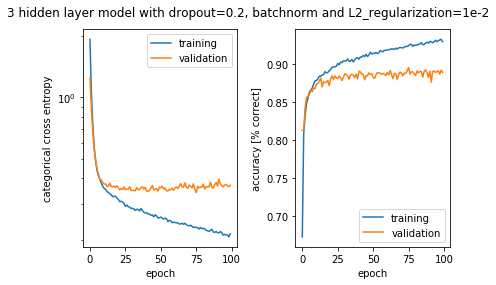

The best validation error of the model with tricks is:  0.8953000009059906
The best validation loss of the model with tricks is:  0.3403556802868843


In [0]:
# plot the learning curves for the model with tricks and regularizations
plot_history(tuned_history, '3 hidden layer model with dropout=0.2, batchnorm and L2_regularization=1e-2')
plt.show()

# display best scores
print('The best validation error of the model with tricks is: ', max(tuned_history.history['val_acc']))
print('The best validation loss of the model with tricks is: ', min(tuned_history.history['val_loss']))

step 2: plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized). Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.)

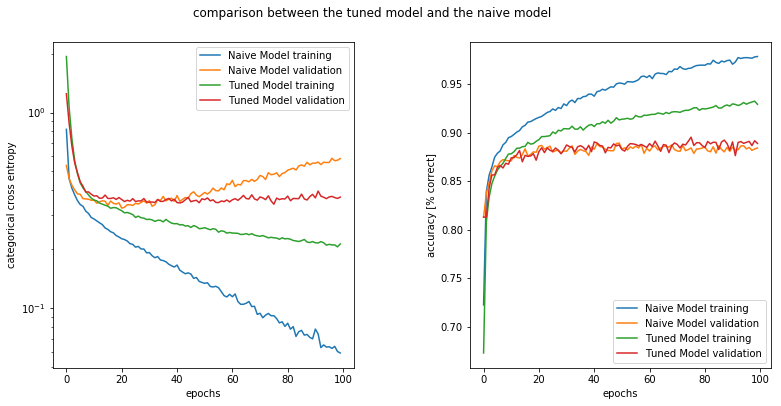

In [0]:
comparison_fig = comparison_plot(history_sgd=naive_history, 
                                history_adam=tuned_history,
                                label1='Naive Model',
                                label2='Tuned Model',
                                title='comparison between the tuned model and the naive model')
comparison_fig.set_figheight(6)
comparison_fig.set_figwidth(12)

reproduce the learning curve for the one hidden layer model in Exercise 3 

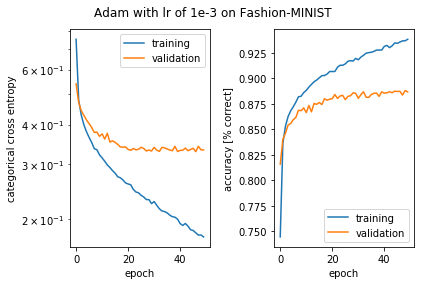

The best validation error of the one hidden layer model is:  0.88789999127388
The best validation loss of the one hidden layer model is:  0.32809359014034273


In [0]:
plot_history(history_fashion_one_hidden_adam, 'Adam with lr of 1e-3 on Fashion-MINIST')
plt.show()

# display best scores for the one hidden layer model in Exercise 3
print('The best validation error of the one hidden layer model is: ', max(history_fashion_one_hidden_adam.history['val_acc']))
print('The best validation loss of the one hidden layer model is: ', min(history_fashion_one_hidden_adam.history['val_loss']))

**Answer to question 2** :

In the comparison plot, we can observe that regularizations/tricks (dropout, weight decay) reduce the training performance (higher training loss and lower training accuracy) but boost the validation performance (lower validation loss and higher validation accuracy). 

Compared to the one-hidden layer in Exercise 3, the naive 3-hidden-layer mdoel achieves marginally higher validation performance (88.93% v.s. 88.79% validation accuracy) but better training record, which proves the claim that more hidden layers do not necessarily improve the validation performance due to overfitting the training data.

step 3: fit the currently best model (3 hidden layer model with tricks) on mnist data

In [0]:
# training parameters
lr = 1e-3 
epochs = 100 
optimizer = Adam 

# the same initialization
tuned_model_three_hidden.set_weights(tuned_three_hidden_inital)

tuned_model_three_hidden.compile(loss='categorical_crossentropy',
                                  optimizer=optimizer(lr=lr),
                                  metrics=['accuracy'])
  
tuned_history_with_mnist = tuned_model_three_hidden.fit(x_train, y_train,
                                                          batch_size=batch_size,
                                                          epochs=epochs,
                                                          verbose=0,
                                                          validation_data=(x_test, y_test))

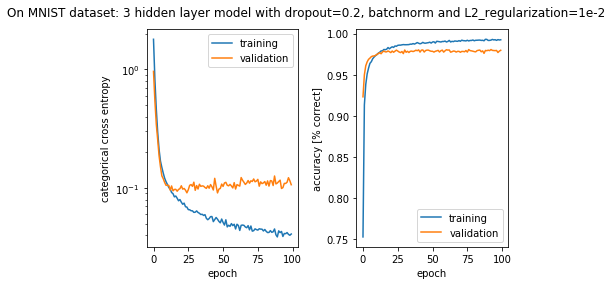

The best validation error of the model with tricks is:  0.9806000089645386
The best validation loss of the model with tricks is:  0.09102538149803877


In [0]:
# plot 
plot_history(tuned_history_with_mnist, 'On MNIST dataset: 3 hidden layer model with dropout=0.2, batchnorm and L2_regularization=1e-2')
plt.show()

# display best scores
print('The best validation error of the model with tricks is: ', max(tuned_history_with_mnist.history['val_acc']))
print('The best validation loss of the model with tricks is: ', min(tuned_history_with_mnist.history['val_loss']))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters(e.g. size of filters, number of layers). Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

step 0: Reload the data as in CNN we have to preserve the image spatial structure

Please note: these data will also be used in Exercise 7

In [0]:
# load into variables
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

# Convert the training set to categorical variable
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [0]:
from keras import backend as K

# Set format of image data
K.set_image_data_format('channels_first')

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols)

# Reshape the data to the format of "channels_first"
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 1, img_rows, img_cols)
x_fashion_test = x_fashion_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)
  
# Normalize data  
x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= 255
x_fashion_test /= 255

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

step 1: Design a CNN and play with different architectures and parameters

In [0]:
epochs = 100
batch_size = 128
num_classes = 10

# Here we repeat the "conv-pool" pattern and use dropout to migitate overfitting.
vgglike = Sequential([
                      Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape),
                      MaxPooling2D(pool_size=(2, 2),strides=2),
                      Dropout(0.2),
                      Conv2D(64, kernel_size=(3, 3), activation='relu'),
                      MaxPooling2D(pool_size=(2, 2),strides=2),
                      Dropout(0.3),
                      Flatten(),
                      Dense(256, activation='relu'),
                      Dropout(0.7),
                      Dense(10, activation='softmax')])

# print summary
vgglike.summary()

# Store the initial weights for later use in fashion-MNIST dataset
initial_weights = vgglike.get_weights()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 28, 28)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 12, 12)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 6, 6)          0         
_________________________________________________________________
dropout_2 (Dropout)  

step2: Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. 

Train on MNIST data

Instructions for updating:
Use tf.cast instead.
Test loss for MNIST: 0.017845606650296213
Test accuracy for MNIST: 0.9935


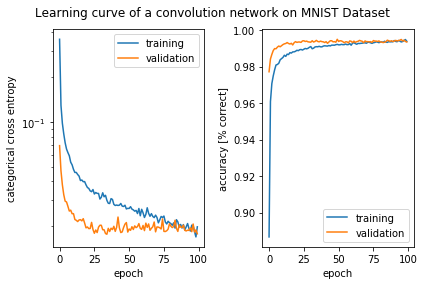

In [0]:
vgglike.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

# training on MNIST 
history = vgglike.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      validation_data=(x_test, y_test))

# validation
score = vgglike.evaluate(x_test, y_test, verbose=0)

# report the performance
print('Test loss for MNIST:', score[0])
print('Test accuracy for MNIST:', score[1])
_ = plot_history(history, 'Learning curve of a convolution network on MNIST Dataset')

repeat the steps for fashion-MNIST dataset

Test loss for fashion-MNIST: 0.2416329441666603
Test accuracy for fashion-MNIST: 0.9252


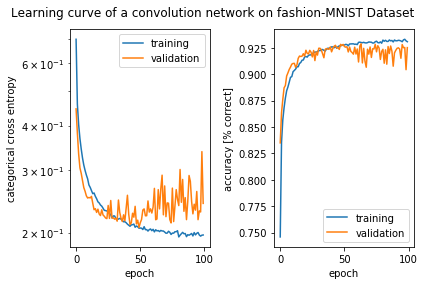

In [0]:
# re-initialize
vgglike.set_weights(initial_weights)
  
vgglike.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

cnn_fashion_history = vgglike.fit(x_fashion_train, y_fashion_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=0,
                                  validation_data=(x_fashion_test, y_fashion_test))
score = vgglike.evaluate(x_fashion_test, y_fashion_test, verbose=0)

print('Test loss for fashion-MNIST:', score[0])
print('Test accuracy for fashion-MNIST:', score[1])
_ = plot_history(cnn_fashion_history, 'Learning curve of a convolution network on fashion-MNIST Dataset')

step 3: How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets?

plot the comparison between the current CNN model the previos best fully-connect model for both MNIST and Fashion MNIST datasets

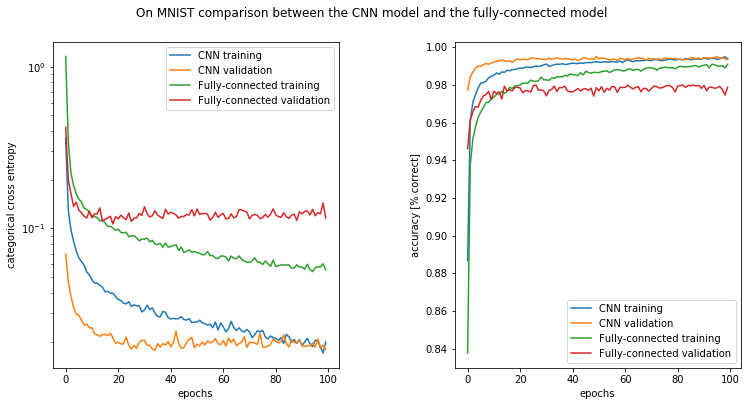

In [0]:
# Comparison on MNIST
comparison_fig = comparison_plot(history_sgd=history, 
                                  history_adam=tuned_history_with_mnist,
                                  label1='CNN',
                                  label2='Fully-connected',
                                  title='On MNIST comparison between the CNN model and the fully-connected model')
comparison_fig.set_figheight(6)
comparison_fig.set_figwidth(12)

Note here as we use dropout in the CNN model, its validation record looks better than its training record.

Comparison on Fashion data

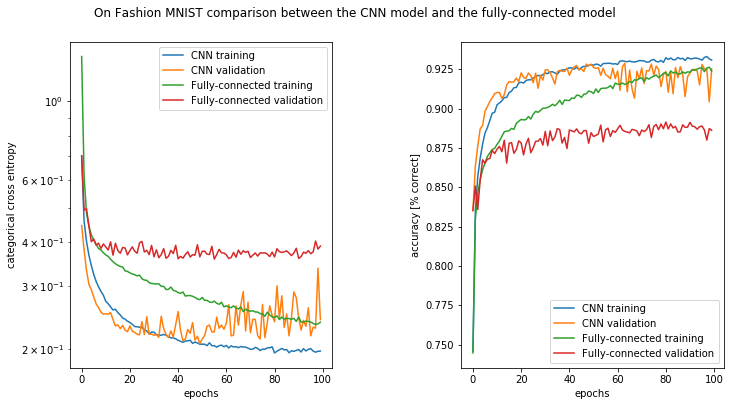

In [0]:
# Comparison on Fashion MNIST
comparison_fig = comparison_plot(history_sgd=cnn_fashion_history, 
                                  history_adam=tuned_history,
                                  label1='CNN',
                                  label2='Fully-connected',
                                  title='On Fashion MNIST comparison between the CNN model and the fully-connected model')
comparison_fig.set_figheight(6)
comparison_fig.set_figwidth(12)

**Answer to question 3:**

Based on the above two comparison plots, the CNN model takes much fewer epochs to converge than the fully connected model on both datesets. 

Also, in terms of both training and validation performances, the CNN model outperforms the fully-connected model by a margin of 1% val. accuracy on MINIST and also 4% val. acc. on Fashion MNIST.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only choose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Note in this exericise, we use the same data (without being flattened) as in exercise 6.

step 1: Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. 

In [0]:
epochs = 100
batch_size = 128
num_classes = 10

model_no_bn = Sequential([
                        Conv2D(32, kernel_size=(3, 3), activation='sigmoid',padding='same',input_shape=input_shape),
                        MaxPooling2D(pool_size=(2, 2),strides=2),
                        Dropout(0.2),
                        Conv2D(64, kernel_size=(3, 3), activation='sigmoid'),
                        MaxPooling2D(pool_size=(2, 2),strides=2),
                        Dropout(0.3),
                        Flatten(),
                        Dense(256, activation='sigmoid'),
                        Dropout(0.7),
                        Dense(10, activation='softmax')
                        ])

model_no_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 28, 28)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 12, 12)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 6, 6)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 6, 6)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

In [0]:
# compile
model_no_bn.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.Adadelta(),
                   metrics=['accuracy'])

cnn_sigmoid_history = model_no_bn.fit(x_fashion_train, y_fashion_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=0,
                                      validation_data=(x_fashion_test, y_fashion_test))
score = model_no_bn.evaluate(x_fashion_test, y_fashion_test, verbose=0)

Test loss for fashion-MNIST: 0.2754583351790905
Test accuracy for fashion-MNIST: 0.9014


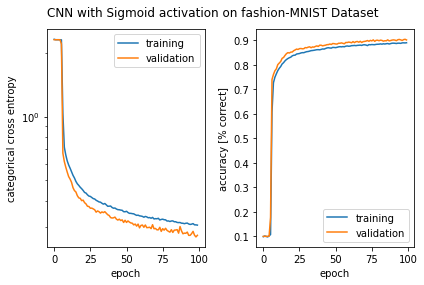

In [0]:
# report the performance
print('Test loss for fashion-MNIST:', score[0])
print('Test accuracy for fashion-MNIST:', score[1])
_  = plot_history(cnn_sigmoid_history, 'CNN with Sigmoid activation on fashion-MNIST Dataset')

Note here we ran the the re-initialized network the second time and plotted the corresponding learning curves below.

Test loss for fashion-MNIST: 2.3026025676727295
Test accuracy for fashion-MNIST: 0.1


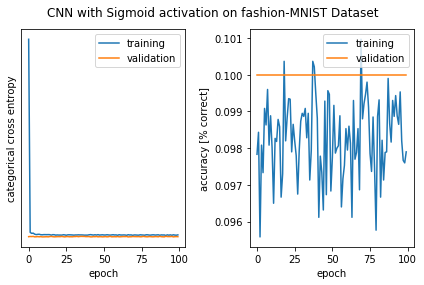

In [0]:
# re-initialize
model_no_bn = Sequential([
                        Conv2D(32, kernel_size=(3, 3), activation='sigmoid',padding='same',input_shape=input_shape),
                        MaxPooling2D(pool_size=(2, 2),strides=2),
                        Dropout(0.2),
                        Conv2D(64, kernel_size=(3, 3), activation='sigmoid'),
                        MaxPooling2D(pool_size=(2, 2),strides=2),
                        Dropout(0.3),
                        Flatten(),
                        Dense(256, activation='sigmoid'),
                        Dropout(0.7),
                        Dense(10, activation='softmax')
                        ])

# compile
model_no_bn.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=keras.optimizers.Adadelta(),
                   metrics=['accuracy'])

cnn_sigmoid_history = model_no_bn.fit(x_fashion_train, y_fashion_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=0,
                                      validation_data=(x_fashion_test, y_fashion_test))
score = model_no_bn.evaluate(x_fashion_test, y_fashion_test, verbose=0)

# report the performance
print('Test loss for fashion-MNIST:', score[0])
print('Test accuracy for fashion-MNIST:', score[1])
_  = plot_history(cnn_sigmoid_history, 'CNN with Sigmoid activation on fashion-MNIST Dataset')

***Answer to question 1***: 

From two runs, we observe that the performance of CNN with sigmoid activation is unstable and highly dependent on initialization, with extreme case where the network cannot be trained (generating random guesses).

step2: Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). 

Note the data has been normalized during loading, so we do not add batch-normalization layer before the first layer.

In [0]:
model_bn = Sequential([
                      Conv2D(32, kernel_size=(3, 3), activation='sigmoid',padding='same',input_shape=input_shape),
                      MaxPooling2D(pool_size=(2, 2),strides=2),
                      Dropout(0.2),
                      BatchNormalization(),
                      Conv2D(64, kernel_size=(3, 3), activation='sigmoid'),
                      MaxPooling2D(pool_size=(2, 2),strides=2),
                      Dropout(0.3),
                      Flatten(),
                      BatchNormalization(),
                      Dense(256, activation='sigmoid'),
                      Dropout(0.7),
                      BatchNormalization(),
                      Dense(10, activation='softmax')
                      ])

model_bn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 28, 28)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 14, 14)        56        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 12, 12)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
# re-train
model_bn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

cnn_bn_history = model_bn.fit(x_fashion_train, y_fashion_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=0,
                              validation_data=(x_fashion_test, y_fashion_test))
score = model_bn.evaluate(x_fashion_test, y_fashion_test, verbose=0)

Test loss for fashion-MNIST: 0.21264181961640716
Test accuracy for fashion-MNIST: 0.9298


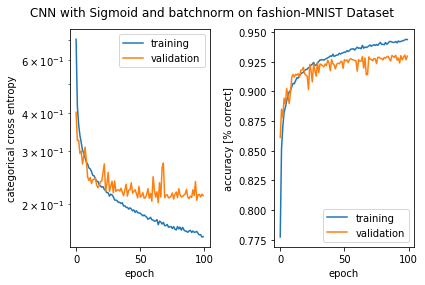

In [0]:
# report performance
print('Test loss for fashion-MNIST:', score[0])
print('Test accuracy for fashion-MNIST:', score[1])
_ = plot_history(cnn_bn_history, 'CNN with Sigmoid and batchnorm on fashion-MNIST Dataset')

Here we can oberve that batch-normalization speeds up the training process, ending at 93% validation accuracy compared to previous 90% validation accuracy. 

comparison plots with ReLU CNN on Fashion data

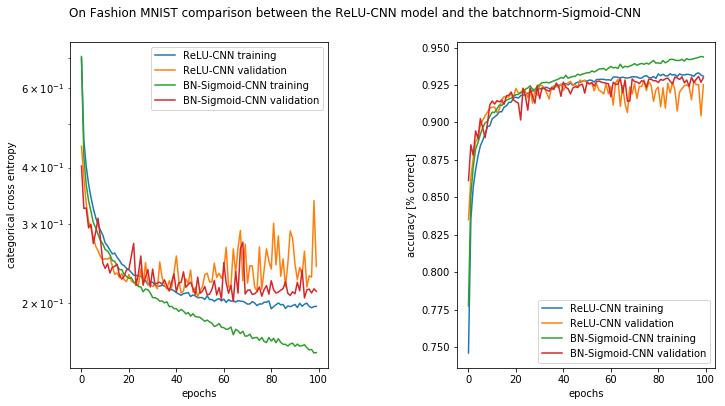

In [0]:
# Comparison on Fashion MNIST
comparison_fig = comparison_plot(history_sgd=cnn_fashion_history, 
                                  history_adam=cnn_bn_history,
                                  label1='ReLU-CNN',
                                  label2='BN-Sigmoid-CNN',
                                  title='On Fashion MNIST comparison between the ReLU-CNN model and the batchnorm-Sigmoid-CNN')
comparison_fig.set_figheight(6)
comparison_fig.set_figwidth(12)

**Answer to question 2:** 

From both the comparison plots and the best performance records, the Sigmoid-CNN with batchnorm achieves a slightly better and more stable performance than ReLU-CNN.